In [1]:
import datetime as dt
import os

import matplotlib.pyplot as plt
import numpy as np

from coropy.compartmental_models import SEIRModel, SEIRDModel

In [2]:
# data
DATA_PATH = os.path.join(os.pardir, 'data')
COUNTRY = 'CRO'
DATA = os.path.join(DATA_PATH, COUNTRY)
CONFIRMED_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'confirmed_cases.dat')
RECOVERED_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'recovered_cases.dat')
DEATH_CASES_PATH = os.path.join(DATA_PATH, COUNTRY, 'death_cases.dat')
TESTS_PATH = os.path.join(DATA_PATH, COUNTRY, 'tests.dat')

confirmed_cases = np.loadtxt(CONFIRMED_CASES_PATH)
recovered_cases = np.loadtxt(RECOVERED_CASES_PATH)
death_cases = np.loadtxt(DEATH_CASES_PATH)
daily_tests = np.loadtxt(TESTS_PATH)

eff_dates=[dt.datetime(2020, 2, 25), dt.datetime(2020, 6, 1), dt.datetime(2020, 8, 8)]

INFO:root:L-BFGS-B optimization started: 2020-10-03 12:13:09.640074
INFO:root:Elapsed time: 2.9986s
INFO:root:L-BFGS-B optimization started: 2020-10-03 12:13:12.651064
INFO:root:Elapsed time: 0.7426s
INFO:root:L-BFGS-B optimization started: 2020-10-03 12:13:13.400413
INFO:root:Elapsed time: 0.8759s


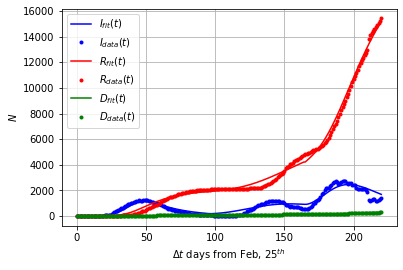

In [3]:
eff_population_scaler = 1
first_wave_eff_population = 2200
S0 = first_wave_eff_population * eff_population_scaler
E0 = 3 * confirmed_cases[0]
I0 = confirmed_cases[0]
R0 = recovered_cases[0]
D0 = death_cases[0]
IC = (S0, E0, I0, R0, D0)

S_tot, E_tot, I_tot, R_tot, D_tot = [], [], [], [], []

# past wave(s)
start_idx = 0
for start_date, end_date in zip(eff_dates[:-1], eff_dates[1:]):
    end_idx = start_idx+abs((end_date - start_date).days)
    model = SEIRDModel()
    _, _ = model.fit(confirmed_cases[start_idx:end_idx], recovered_cases[start_idx:end_idx], death_cases[start_idx:end_idx], IC)
    (S, E, I, R, D) = model.simulate()
    S_tot.extend(S.tolist())
    E_tot.extend(E.tolist())
    I_tot.extend(I.tolist())
    R_tot.extend(R.tolist())
    D_tot.extend(D.tolist())
    
    eff_population_scaler += 1
    S0 = S0 * eff_population_scaler
    IC = (S0, 3 * I[-1], I[-1], R[-1], D[-1])  # update initial conditions
    start_idx = end_idx  # update indexing

# current wave   
model = SEIRDModel()
_, _ = model.fit(confirmed_cases[start_idx:], recovered_cases[start_idx:], death_cases[start_idx:], IC)
(S, E, I, R, D) = model.simulate()
S_tot.extend(S.tolist())
E_tot.extend(E.tolist())
I_tot.extend(I.tolist())
R_tot.extend(R.tolist())
D_tot.extend(D.tolist())

# visualize
fig, ax = plt.subplots()
ax.plot(I_tot, 'b-', label='$I_{fit}(t)$')
ax.plot(confirmed_cases - recovered_cases - death_cases, 'b.', label='$I_{data}(t)$')
ax.plot(R_tot, 'r-', label='$R_{fit}(t)$')
ax.plot(recovered_cases, 'r.', label='$R_{data}(t)$')
ax.plot(D_tot, 'g-', label='$D_{fit}(t)$')
ax.plot(death_cases, 'g.', label='$D_{data}(t)$')
ax.set_xlabel('$\Delta t$ days from Feb, $25^{th}$')
ax.set_ylabel('$N$')
ax.legend()
ax.grid()
plt.show()